<a href="https://colab.research.google.com/github/ideepankarsharma2003/Machine-Learning/blob/main/03_NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Style Transfer**

# Importing Packages


In [58]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

# Pretrained Weights

In [59]:
tf.random.set_seed(272) 
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                #   weights=`imagenet`)
                                  weights='/content/drive/MyDrive/Colab Notebooks/03-Computer-Vision/weights-for-vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

 Content Image

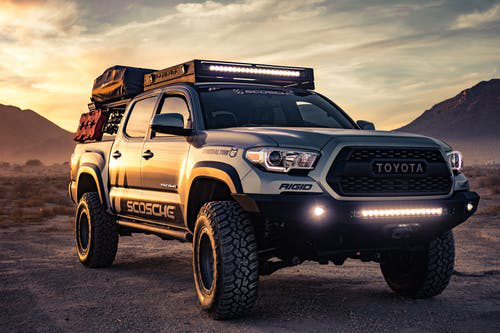

In [60]:
# content_image = Image.open("/content/drive/MyDrive/Colab Notebooks/03-Computer-Vision/images/uploaded/deepankar.jpg")
content_image = Image.open("/content/drive/MyDrive/Colab Notebooks/03-Computer-Vision/images/uploaded/truck.jpg")
content_image

## Content Cost

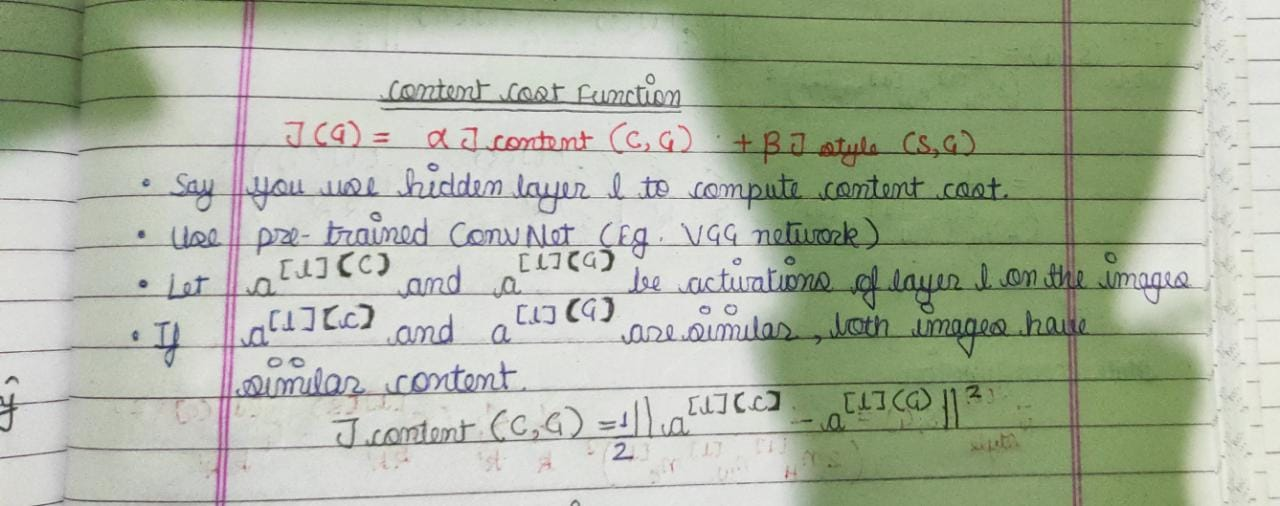

In [61]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    
#     _, n_H, n_W, n_C = None
    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    
#     a_C_unrolled = None
#     a_G_unrolled = None
    a_C_unrolled = tf.reshape(
    a_C, shape=[_, n_H * n_W, n_C], name=None
)
    a_G_unrolled = tf.reshape(
    a_G, shape=[_, n_H * n_W, n_C], name=None
)
    
#     J_content = None
    J_content= tf.subtract(a_C_unrolled, a_G_unrolled)
    J_content= tf.square(J_content)
    J_content= tf.reduce_sum(J_content)
    J_content= (1/(4*n_H*n_W*n_C))*(J_content)
    
    
    
    return J_content

 Style Image

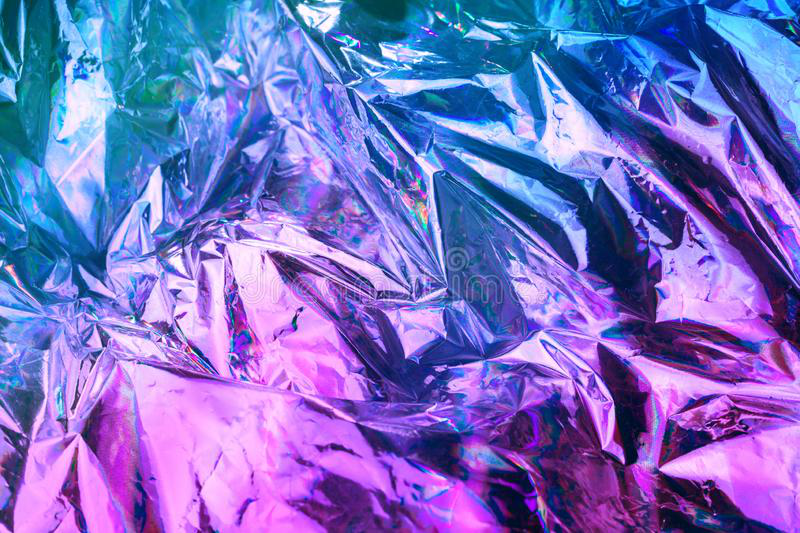

In [62]:
example = Image.open("/content/drive/MyDrive/Colab Notebooks/03-Computer-Vision/images/uploaded/vapourwave.jpg")
example

## Gram-Matrix

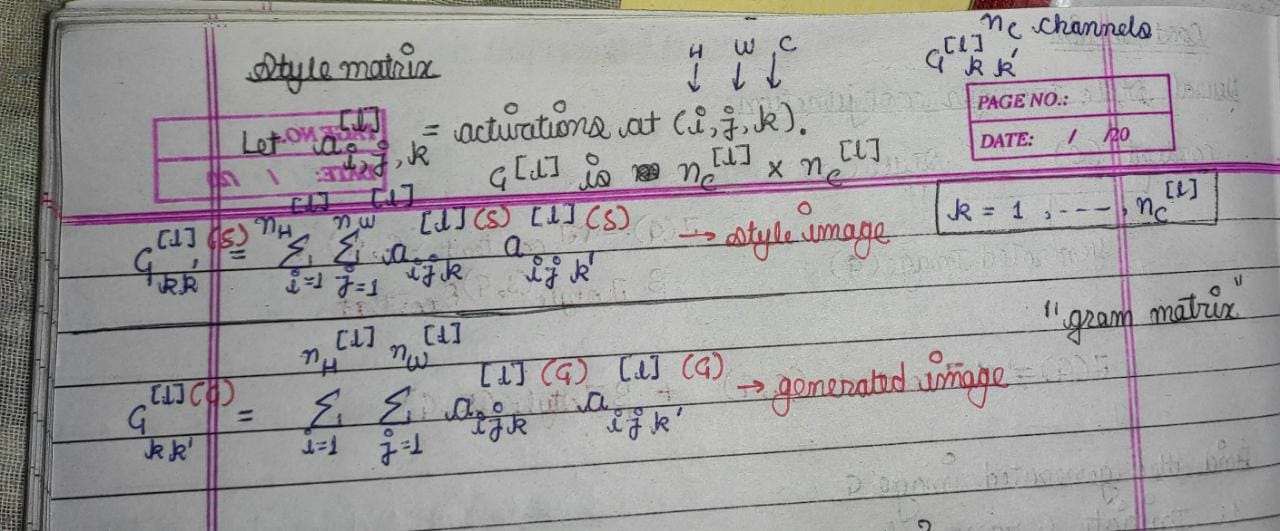

In [63]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  

#     GA = None
    b=tf.transpose(
    A, perm=None, conjugate=False, name='transpose'
)
    
    GA = tf.linalg.matmul(
    a=A, b=b
)
    

    return GA

## Style Cost

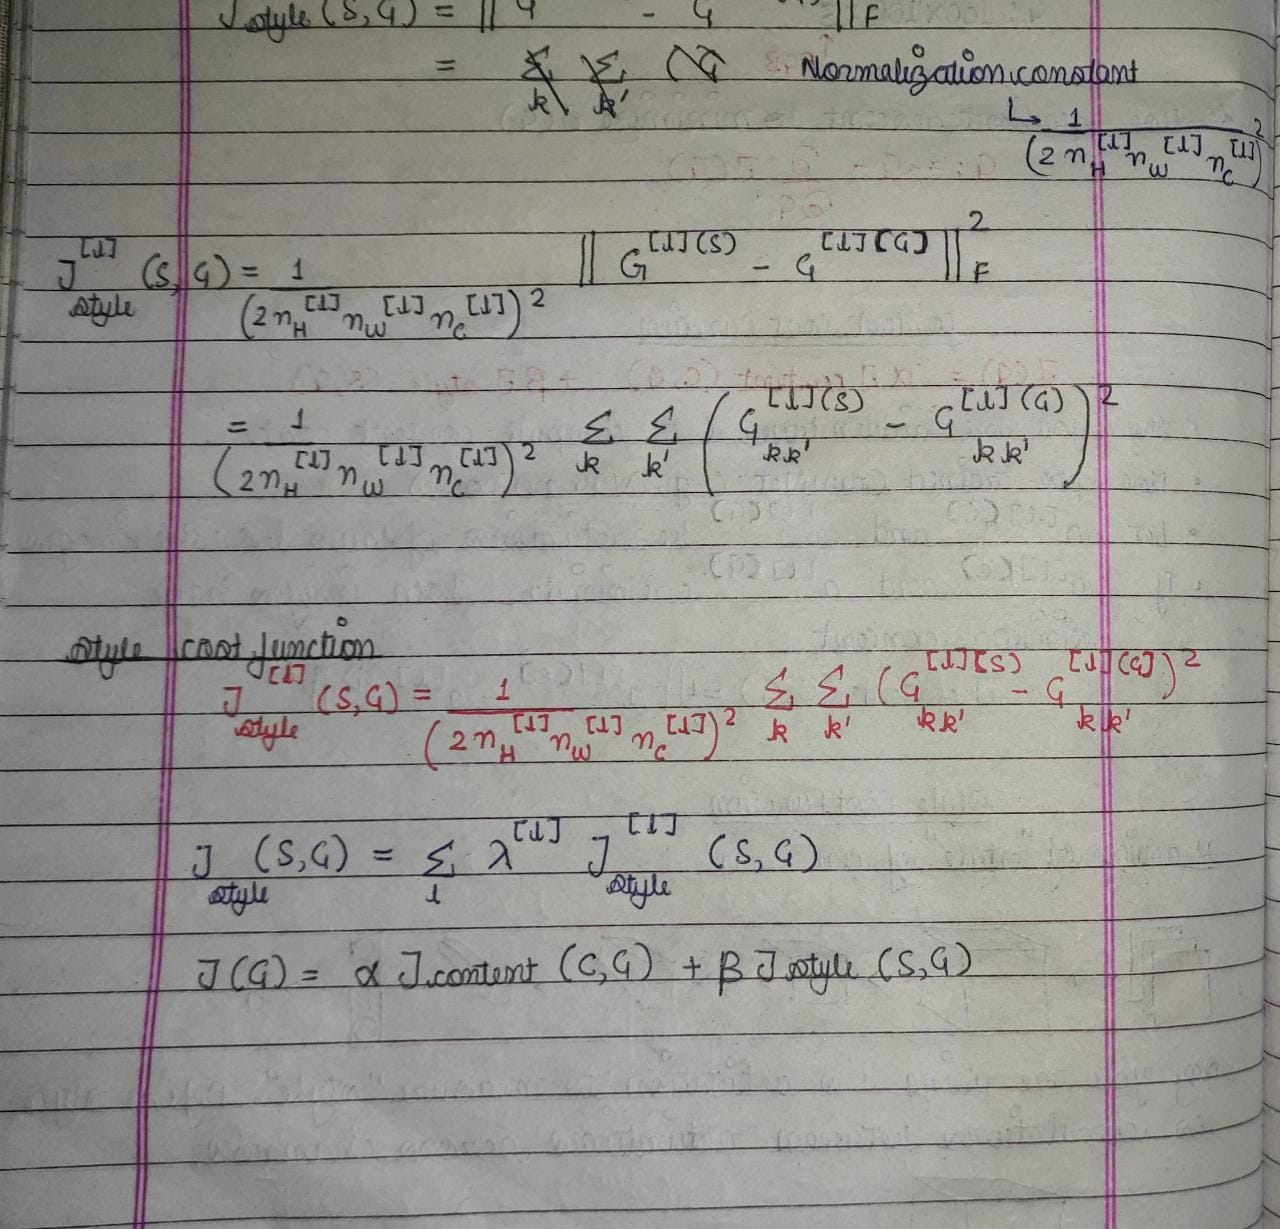

In [64]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    

    
    a_S = (tf.reshape(a_S, shape=[-1, n_C]))
    a_G = (tf.reshape(a_G, shape=[-1, n_C]))

    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

    J_style_layer = tf.subtract(GS, GG)
    J_style_layer = tf.square(J_style_layer)
    J_style_layer = tf.reduce_sum(J_style_layer)
    
    x=(4.0  *  (n_C**2)  *  ((n_H*n_W )**2) )
    x=1/x
    J_style_layer=  x*J_style_layer

    
    
    
#     print(J_style_layer)
e    return J_style_layer

# Style Weights

In [65]:
for layer in vgg.layers:
    print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [66]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [67]:
# choose layers to represent the style of the image and assign style costs
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [68]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

## Total Cost to Optimize

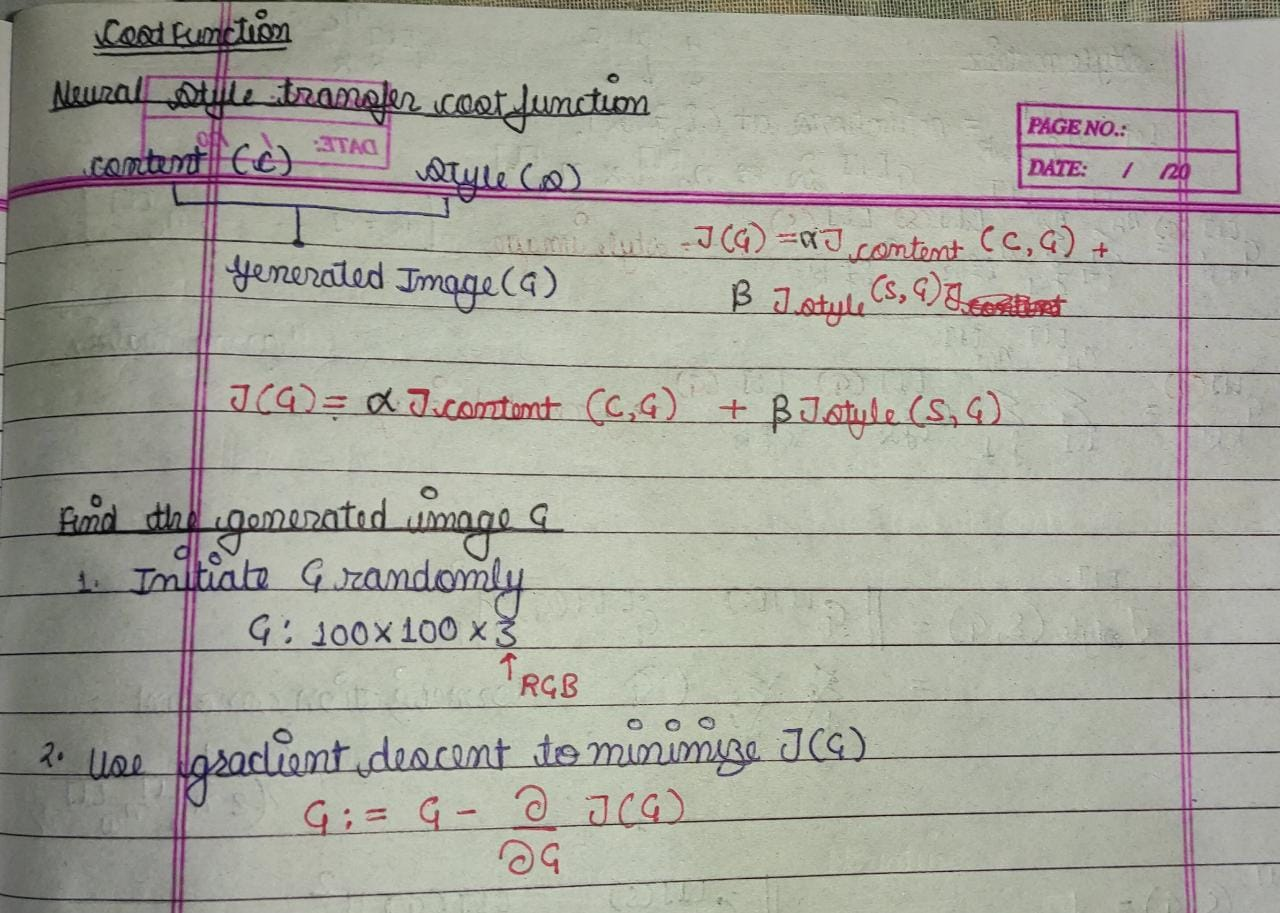

In [69]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J= alpha*J_content + beta*J_style
    

    return J

## Load Content Image

(1, 400, 400, 3)


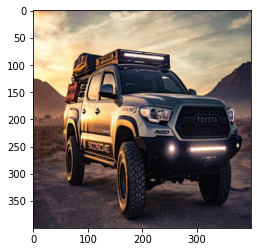

In [89]:
# content_image = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/03-Computer-Vision/images/uploaded/deepankar.jpg").resize((img_size, img_size)))
content_image = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/03-Computer-Vision/images/uploaded/truck.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

# Load Style Image

(1, 400, 400, 3)


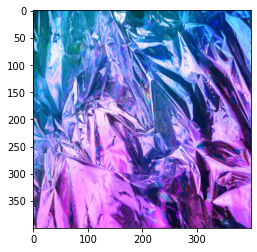

In [90]:
style_image =  np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/03-Computer-Vision/images/uploaded/vapourwave.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

In [ ]:
content_image

# Randomly Initialize The  Image to be generated

In [91]:
img=tf.image.convert_image_dtype(
    image=content_image, dtype=tf.float32, saturate=False, name=None
)


(1, 400, 400, 3)


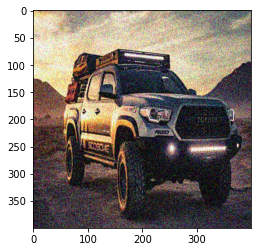

In [92]:
generated_image = tf.Variable(img)
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

# Load Pre-Trained VGG19 Model

In [93]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [95]:
# define the content layer of the model
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [96]:
# save outputs
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

## Compute Total Cost

Compute the Content image Encoding (a_C)

In [78]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

Compute the Style image Encoding (a_S)

In [79]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [80]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

## Training

In [99]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        
        a_G= vgg_model_outputs(generated_image)
        
        # Compute the style cost

        J_style = compute_style_cost(a_S, a_G)
        # Compute the content cost


        # compute_content_cost(content_output, generated_output)
        J_content = compute_content_cost(a_C, a_G)
        
        
        # Compute the total cost
        J = total_cost(J_content, J_style, alpha = 10, beta = 40)
        


        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J
#     return J+15407.7142

In [103]:
generated_image = tf.Variable(generated_image)


J1 = train_step(generated_image)
print(J1)


# J2 = train_step(generated_image)
# print(J2)

print("\033[92mAll tests passed")

TypeError: ignored

In [100]:
train_step(generated_image)


ValueError: ignored

In [87]:
# # Show the generated image at some epochs
# epochs = 10000
# for i in range(epochs):
#     train_step(generated_image)
#     if i % 250 == 0:
#         print(f"Epoch {i} ")
#     if i % 250 == 0:
#         image = tensor_to_image(generated_image)
#         imshow(image)
#         image.save(f"output/image_{i}.jpg")
#         plt.show() 

ValueError: ignored

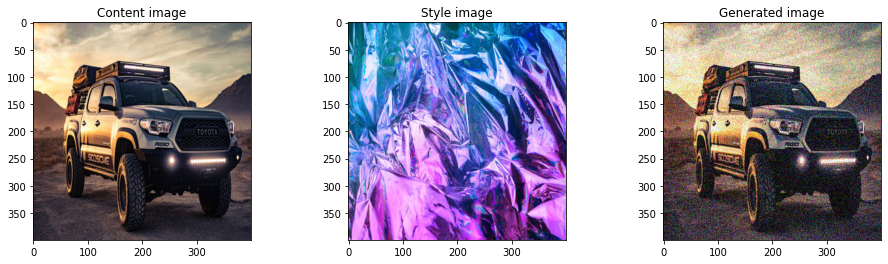

In [97]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()